Error saat memutar audio di thread: 'NoneType' object has no attribute 'wait'
Error saat memutar audio di thread: 'NoneType' object has no attribute 'wait'
Error saat memutar audio di thread: 'NoneType' object has no attribute 'wait'


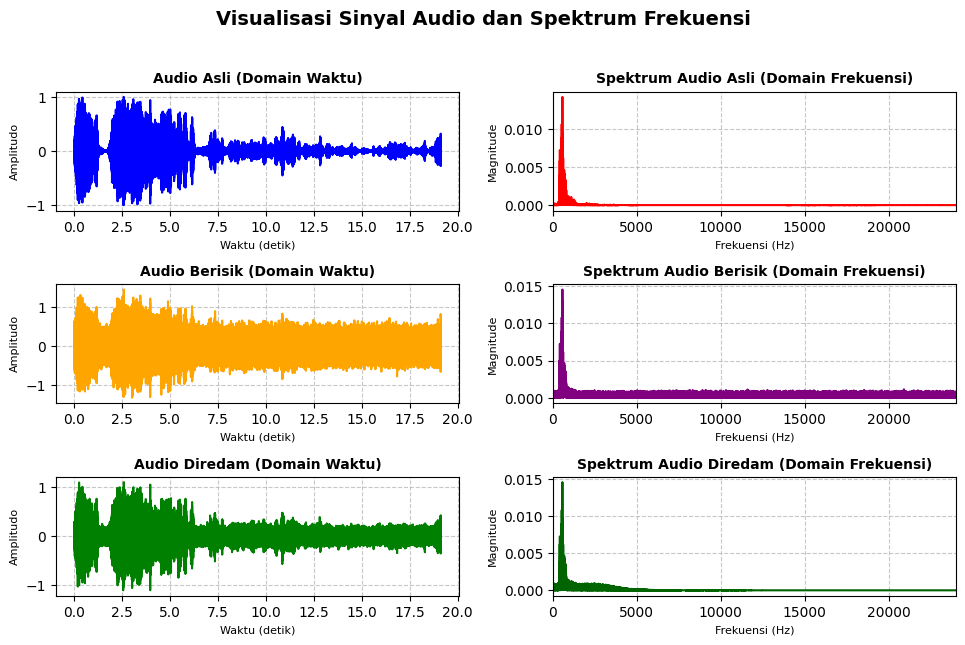

In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox
import soundfile as sf
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import sounddevice as sd
import threading # Untuk menjalankan pemutaran audio di thread terpisah
import time # Untuk jeda singkat di thread

class AudioProcessorApp:
    """
    Kelas utama untuk aplikasi pengolah audio dengan GUI Tkinter.
    Aplikasi ini memungkinkan pengguna untuk memuat audio, menambahkan noise,
    mereduksi noise, memvisualisasikan sinyal, dan memutar audio.
    """
    def __init__(self, master):
        self.master = master
        master.title("Mini Proyek: Reduksi Noise Audio")
        master.geometry("1000x950") # Mengatur ukuran awal jendela aplikasi agar lebih tinggi untuk banyak plot

        # Variabel untuk menyimpan data audio
        self.original_audio = None
        self.noisy_audio = None
        self.denoised_audio = None
        self.samplerate = None # Frekuensi sampling audio

        # Variabel untuk mengelola pemutaran audio
        self.current_playback_stream = None
        self.playback_thread = None
        self.is_playing = False # Flag untuk melacak status pemutaran

        # --- Frame untuk Kontrol Utama (Tombol Proses) ---
        self.process_control_frame = tk.Frame(master, bd=2, relief="groove", padx=10, pady=10)
        self.process_control_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)

        self.load_button = tk.Button(self.process_control_frame, text="1. Muat Audio (.wav)", command=self.load_audio,
                                     font=("Helvetica", 10, "bold"), bg="#4CAF50", fg="white", relief="raised")
        self.load_button.grid(row=0, column=0, padx=5, pady=5, sticky="ew")

        self.add_noise_button = tk.Button(self.process_control_frame, text="2. Tambah Noise Buatan", command=self.add_noise, state=tk.DISABLED,
                                          font=("Helvetica", 10, "bold"), bg="#FFC107", fg="black", relief="raised")
        self.add_noise_button.grid(row=0, column=1, padx=5, pady=5, sticky="ew")

        self.denoise_button = tk.Button(self.process_control_frame, text="3. Reduksi Noise (Filter)", command=self.denoise_audio, state=tk.DISABLED,
                                         font=("Helvetica", 10, "bold"), bg="#2196F3", fg="white", relief="raised")
        self.denoise_button.grid(row=0, column=2, padx=5, pady=5, sticky="ew")

        # Konfigurasi kolom agar tombol merata
        self.process_control_frame.grid_columnconfigure(0, weight=1)
        self.process_control_frame.grid_columnconfigure(1, weight=1)
        self.process_control_frame.grid_columnconfigure(2, weight=1)

        # --- Frame untuk Kontrol Pemutaran Audio Per Kategori ---
        self.playback_category_frame = tk.Frame(master, bd=2, relief="groove", padx=10, pady=10)
        self.playback_category_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)

        # Kontrol untuk Audio Asli
        tk.Label(self.playback_category_frame, text="Audio Asli:", font=("Helvetica", 10, "bold")).grid(row=0, column=0, padx=5, pady=2, sticky="w")
        self.play_original_button = tk.Button(self.playback_category_frame, text="► Putar Asli", command=lambda: self.start_playback(self.original_audio), state=tk.DISABLED,
                                               font=("Helvetica", 10), bg="#008CBA", fg="white", relief="raised")
        self.play_original_button.grid(row=0, column=1, padx=5, pady=5, sticky="ew")

        # Kontrol untuk Audio Berisik
        tk.Label(self.playback_category_frame, text="Audio Berisik:", font=("Helvetica", 10, "bold")).grid(row=1, column=0, padx=5, pady=2, sticky="w")
        self.play_noisy_button = tk.Button(self.playback_category_frame, text="► Putar Berisik", command=lambda: self.start_playback(self.noisy_audio), state=tk.DISABLED,
                                            font=("Helvetica", 10), bg="#008CBA", fg="white", relief="raised")
        self.play_noisy_button.grid(row=1, column=1, padx=5, pady=5, sticky="ew")

        # Kontrol untuk Audio Diredam
        tk.Label(self.playback_category_frame, text="Audio Diredam:", font=("Helvetica", 10, "bold")).grid(row=2, column=0, padx=5, pady=2, sticky="w")
        self.play_denoised_button = tk.Button(self.playback_category_frame, text="► Putar Diredam", command=lambda: self.start_playback(self.denoised_audio), state=tk.DISABLED,
                                               font=("Helvetica", 10), bg="#008CBA", fg="white", relief="raised")
        self.play_denoised_button.grid(row=2, column=1, padx=5, pady=5, sticky="ew")

        # Tombol Hentikan Pemutaran Global
        self.stop_all_playback_button = tk.Button(self.playback_category_frame, text="■ Hentikan Semua Pemutaran", command=self.stop_playback, state=tk.DISABLED,
                                                  font=("Helvetica", 10, "bold"), bg="#F44336", fg="white", relief="raised")
        self.stop_all_playback_button.grid(row=0, column=2, rowspan=3, padx=10, pady=5, sticky="ns") # Membentang 3 baris

        # Konfigurasi kolom agar tombol merata
        self.playback_category_frame.grid_columnconfigure(0, weight=0) # Kolom label tidak terlalu lebar
        self.playback_category_frame.grid_columnconfigure(1, weight=1)
        self.playback_category_frame.grid_columnconfigure(2, weight=1)


        # Label untuk menampilkan status aplikasi
        self.status_label = tk.Label(master, text="Status: Siap", fg="blue", font=("Helvetica", 10, "italic"))
        self.status_label.pack(side=tk.TOP, fill=tk.X, padx=10, pady=5)

        # --- Frame untuk Plot ---
        self.plot_frame = tk.Frame(master, bd=2, relief="groove")
        self.plot_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True, padx=10, pady=10)

        # Inisialisasi figure dan axes Matplotlib untuk 6 plot (3 baris x 2 kolom)
        # Baris 0: Asli (Waktu, Frekuensi)
        # Baris 1: Berisik (Waktu, Frekuensi)
        # Baris 2: Diredam (Waktu, Frekuensi)
        self.fig, ((self.ax_orig_time, self.ax_orig_freq),
                   (self.ax_noisy_time, self.ax_noisy_freq),
                   (self.ax_denoised_time, self.ax_denoised_freq)) = plt.subplots(3, 2, figsize=(9, 8))

        self.fig.suptitle("Visualisasi Sinyal Audio dan Spektrum Frekuensi", fontsize=14, fontweight='bold')
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Menyesuaikan layout agar judul tidak tumpang tindih

        self.canvas = FigureCanvasTkAgg(self.fig, master=self.plot_frame)
        self.canvas_widget = self.canvas.get_tk_widget()
        self.canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.toolbar = NavigationToolbar2Tk(self.canvas, self.plot_frame)
        self.toolbar.update()
        self.canvas_widget.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Mengatur status awal
        self.update_status("Siap untuk memuat audio Anda.")

        # Mengikat event penutupan jendela untuk menghentikan pemutaran audio
        self.master.protocol("WM_DELETE_WINDOW", self.on_closing)

    def on_closing(self):
        """
        Menghentikan pemutaran audio jika sedang berjalan sebelum menutup aplikasi.
        """
        self.stop_playback()
        self.master.destroy()

    def update_status(self, message, color="blue"):
        """
        Memperbarui teks status pada label di GUI.
        """
        self.status_label.config(text=f"Status: {message}", fg=color)
        self.master.update_idletasks() # Memaksa pembaruan GUI segera

    def load_audio(self):
        """
        Membuka dialog file untuk memilih file audio WAV,
        kemudian memuat dan memprosesnya.
        """
        self.stop_playback() # Hentikan pemutaran sebelumnya jika ada
        try:
            file_path = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
            if not file_path:
                self.update_status("Pemuatan audio dibatalkan.", "orange")
                return

            self.original_audio, self.samplerate = sf.read(file_path)

            if self.original_audio.ndim > 1:
                self.original_audio = self.original_audio.mean(axis=1) # Konversi ke mono

            self.update_status(f"Audio '{file_path.split('/')[-1]}' berhasil dimuat. Samplerate: {self.samplerate} Hz", "green")

            # Reset audio berisik dan diredam
            self.noisy_audio = None
            self.denoised_audio = None

            # Aktifkan tombol-tombol
            self.add_noise_button.config(state=tk.NORMAL)
            self.play_original_button.config(state=tk.NORMAL)
            self.stop_all_playback_button.config(state=tk.DISABLED) # Awalnya nonaktif sampai pemutaran dimulai

            # Nonaktifkan tombol pemutaran/visualisasi untuk noise/denoised sampai diproses
            self.play_noisy_button.config(state=tk.DISABLED)
            self.play_denoised_button.config(state=tk.DISABLED)

            # Plot semua audio (saat ini hanya asli yang ada)
            self.plot_all_audio()

        except Exception as e:
            messagebox.showerror("Error", f"Gagal memuat audio: {e}\nPastikan file WAV valid.")
            self.update_status("Gagal memuat audio.", "red")
            self.reset_app_state()

    def add_noise(self):
        """
        Menambahkan noise putih buatan ke sinyal audio asli.
        """
        if self.original_audio is None:
            messagebox.showwarning("Peringatan", "Muat audio terlebih dahulu sebelum menambahkan noise.")
            return

        self.stop_playback() # Hentikan pemutaran sebelumnya jika ada
        try:
            noise_amplitude = 0.15 * np.max(np.abs(self.original_audio))
            noise = noise_amplitude * np.random.randn(len(self.original_audio))
            self.noisy_audio = self.original_audio + noise

            self.update_status("Noise buatan berhasil ditambahkan.", "green")

            # Aktifkan tombol reduksi noise dan pemutaran/visualisasi audio berisik
            self.denoise_button.config(state=tk.NORMAL)
            self.play_noisy_button.config(state=tk.NORMAL)

            # Nonaktifkan tombol pemutaran/visualisasi untuk denoised sampai diproses
            self.play_denoised_button.config(state=tk.DISABLED)

            # Plot semua audio (asli dan berisik)
            self.plot_all_audio()

        except Exception as e:
            messagebox.showerror("Error", f"Gagal menambahkan noise: {e}")
            self.update_status("Gagal menambahkan noise.", "red")

    def denoise_audio(self):
        """
        Menerapkan filter low-pass Butterworth untuk mereduksi noise
        dari sinyal audio yang berisik.
        """
        if self.noisy_audio is None:
            messagebox.showwarning("Peringatan", "Tambahkan noise terlebih dahulu sebelum mereduksi.")
            return

        self.stop_playback() # Hentikan pemutaran sebelumnya jika ada
        try:
            cutoff_freq = 3500 # Hz
            nyquist_freq = 0.5 * self.samplerate
            normalized_cutoff = cutoff_freq / nyquist_freq
            order = 5

            b, a = signal.butter(order, normalized_cutoff, btype='low', analog=False)
            self.denoised_audio = signal.lfilter(b, a, self.noisy_audio)

            self.update_status("Reduksi noise berhasil diterapkan.", "green")

            # Aktifkan tombol pemutaran/visualisasi audio diredam
            self.play_denoised_button.config(state=tk.NORMAL)

            # Plot semua audio (asli, berisik, dan diredam)
            self.plot_all_audio()

        except Exception as e:
            messagebox.showerror("Error", f"Gagal mereduksi noise: {e}")
            self.update_status("Gagal mereduksi noise.", "red")

    def plot_all_audio(self):
        """
        Memplot sinyal audio dalam domain waktu dan frekuensi untuk semua tahapan (asli, berisik, diredam).
        """
        # Clear all axes
        for ax_row in self.fig.axes:
            ax_row.clear()

        # Helper function to plot a single audio's time and frequency domain
        def plot_single_audio(audio_data, time_ax, freq_ax, title_prefix, color_time='blue', color_freq='red'):
            if audio_data is None or self.samplerate is None:
                time_ax.set_title(f"{title_prefix} (Tidak Ada Data)", fontsize=10, fontweight='bold', color='gray')
                freq_ax.set_title(f"Spektrum {title_prefix} (Tidak Ada Data)", fontsize=10, fontweight='bold', color='gray')
                time_ax.set_xticks([])
                time_ax.set_yticks([])
                freq_ax.set_xticks([])
                freq_ax.set_yticks([])
                return

            # Plot Domain Waktu
            time = np.linspace(0, len(audio_data) / self.samplerate, len(audio_data))
            time_ax.plot(time, audio_data, color=color_time)
            time_ax.set_title(f"{title_prefix} (Domain Waktu)", fontsize=10, fontweight='bold')
            time_ax.set_xlabel("Waktu (detik)", fontsize=8)
            time_ax.set_ylabel("Amplitudo", fontsize=8)
            time_ax.grid(True, linestyle='--', alpha=0.7)

            # Plot Domain Frekuensi (FFT)
            N = len(audio_data)
            yf = np.fft.fft(audio_data)
            xf = np.fft.fftfreq(N, 1 / self.samplerate)
            positive_freq_idx = np.where(xf >= 0)
            freq_ax.plot(xf[positive_freq_idx], 2.0/N * np.abs(yf[positive_freq_idx]), color=color_freq)
            freq_ax.set_title(f"Spektrum {title_prefix} (Domain Frekuensi)", fontsize=10, fontweight='bold')
            freq_ax.set_xlabel("Frekuensi (Hz)", fontsize=8)
            freq_ax.set_ylabel("Magnitude", fontsize=8)
            freq_ax.set_xlim(0, self.samplerate / 2)
            freq_ax.grid(True, linestyle='--', alpha=0.7)

        # Plot Original Audio
        plot_single_audio(self.original_audio, self.ax_orig_time, self.ax_orig_freq, "Audio Asli", 'blue', 'red')

        # Plot Noisy Audio
        plot_single_audio(self.noisy_audio, self.ax_noisy_time, self.ax_noisy_freq, "Audio Berisik", 'orange', 'purple')

        # Plot Denoised Audio
        plot_single_audio(self.denoised_audio, self.ax_denoised_time, self.ax_denoised_freq, "Audio Diredam", 'green', 'darkgreen')

        self.fig.tight_layout(rect=[0, 0.03, 1, 0.96]) # Menyesuaikan layout setelah semua plot digambar
        self.canvas.draw()

    def _play_audio_thread(self, audio_data, samplerate):
        """
        Fungsi yang akan dijalankan di thread terpisah untuk memutar audio.
        """
        try:
            # Pastikan tidak ada pemutaran lain yang aktif dari thread ini
            if self.current_playback_stream and self.current_playback_stream.active:
                self.current_playback_stream.stop()
                self.current_playback_stream.close()
                time.sleep(0.1) # Beri waktu singkat untuk stream menutup

            self.is_playing = True
            self.stop_all_playback_button.config(state=tk.NORMAL) # Aktifkan tombol stop

            # sd.play() mengembalikan stream, simpan untuk kontrol di luar thread
            self.current_playback_stream = sd.play(audio_data, samplerate, blocking=False)

            # Tunggu hingga stream selesai diputar
            self.current_playback_stream.wait()

            # Setelah pemutaran selesai (atau dihentikan), update status
            if not self.current_playback_stream.active: # Cek apakah stream tidak aktif (berarti selesai/dihentikan)
                self.update_status("Pemutaran selesai.", "green")
                self.is_playing = False
                self.stop_all_playback_button.config(state=tk.DISABLED) # Nonaktifkan tombol stop setelah selesai
        except Exception as e:
            # Tangani error pemutaran di dalam thread
            print(f"Error saat memutar audio di thread: {e}")
            self.update_status("Gagal memutar audio. Cek konsol untuk detail.", "red")
            self.is_playing = False
            self.stop_all_playback_button.config(state=tk.DISABLED) # Nonaktifkan tombol stop jika ada error

    def start_playback(self, audio_data):
        """
        Memulai pemutaran audio di thread terpisah.
        """
        if audio_data is None or self.samplerate is None:
            messagebox.showwarning("Peringatan", "Tidak ada audio untuk diputar.")
            return

        # Hentikan pemutaran yang sedang berjalan sebelum memulai yang baru
        self.stop_playback()
        time.sleep(0.1) # Beri jeda singkat untuk memastikan stream sebelumnya berhenti total

        self.update_status("Memutar audio...", "purple")

        # Buat dan mulai thread baru untuk pemutaran audio
        # Pastikan hanya ada satu thread pemutaran aktif pada satu waktu
        if self.playback_thread and self.playback_thread.is_alive():
            # Jika thread sebelumnya masih berjalan (meskipun sudah di-stop), tunggu sebentar
            self.playback_thread.join(timeout=0.2)

        self.playback_thread = threading.Thread(target=self._play_audio_thread,
                                                args=(audio_data, self.samplerate))
        self.playback_thread.daemon = True # Set sebagai daemon agar thread berhenti saat aplikasi ditutup
        self.playback_thread.start()

    def stop_playback(self):
        """
        Menghentikan pemutaran audio yang sedang berjalan.
        """
        if self.is_playing: # Cek apakah ada pemutaran aktif
            if self.current_playback_stream and self.current_playback_stream.active:
                sd.stop() # Menghentikan stream sounddevice
                self.current_playback_stream.close() # Tutup stream
                self.current_playback_stream = None # Hapus referensi stream

            # Tunggu sebentar agar thread pemutaran bisa menyelesaikan prosesnya
            if self.playback_thread and self.playback_thread.is_alive():
                self.playback_thread.join(timeout=0.2) # Beri waktu singkat untuk thread berakhir

            self.is_playing = False
            self.update_status("Pemutaran dihentikan.", "orange")
            self.stop_all_playback_button.config(state=tk.DISABLED) # Nonaktifkan tombol stop

    def reset_app_state(self):
        """
        Mengatur ulang status aplikasi ke kondisi awal.
        """
        self.original_audio = None
        self.noisy_audio = None
        self.denoised_audio = None
        self.samplerate = None
        self.stop_playback()

        self.add_noise_button.config(state=tk.DISABLED)
        self.denoise_button.config(state=tk.DISABLED)
        self.play_original_button.config(state=tk.DISABLED)
        self.play_noisy_button.config(state=tk.DISABLED)
        self.play_denoised_button.config(state=tk.DISABLED)
        self.stop_all_playback_button.config(state=tk.DISABLED)

        self.plot_all_audio() # Plot ulang dengan data kosong
        self.update_status("Aplikasi direset. Siap untuk memuat audio baru.", "blue")


# Bagian utama aplikasi
if __name__ == "__main__":
    root = tk.Tk()
    app = AudioProcessorApp(root)
    root.mainloop()
